In [1]:
import os
import numpy as np

BASE_PATH = '/home/mgraca/Workspace/hrrr-smoke-viz'
DATA_PATH = os.path.join(BASE_PATH, 'pwwb-experiments/tensorflow/final_input_data/2025-11-21')

In [2]:
X_train = np.load(os.path.join(DATA_PATH, 'X_train.npy'))
X_valid = np.load(os.path.join(DATA_PATH, 'X_valid.npy'))
X_test = np.load(os.path.join(DATA_PATH, 'X_test.npy'))
Y_train = np.load(os.path.join(DATA_PATH, 'Y_train.npy'))
Y_valid = np.load(os.path.join(DATA_PATH, 'Y_valid.npy'))
Y_test = np.load(os.path.join(DATA_PATH, 'Y_test.npy'))

# initially fit data for conv3d, but should squeeze out the frame dimension
X_train = np.squeeze(X_train)
X_valid = np.squeeze(X_valid)
X_test = np.squeeze(X_test)
Y_train = np.squeeze(Y_train)
Y_valid = np.squeeze(Y_valid)
Y_test = np.squeeze(Y_test)

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(12279, 40, 40, 14) (12279, 40, 40)
(2631, 40, 40, 14) (2631, 40, 40)
(2631, 40, 40, 14) (2631, 40, 40)


In [3]:
input_shape = X_train.shape[1:]
air_sens_loc = {
    'Reseda' : (8, 3),
    'North Holywood' : (8, 11),
    'Los Angeles - N. Main Street' : (15, 16),
    'Compton' : (23, 17),
    'Long Beach Signal Hill' : (29, 19),
    'Anaheim' : (27, 29),
    'Glendora - Laurel' : (10, 33)
}

print(input_shape)

(40, 40, 14)


In [4]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D, Conv2D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape, GlobalAveragePooling2D
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=input_shape)
)

seq.add(
    Conv2D(
        filters=15,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
    )
)

seq.add(
    Conv2D(
        filters=30,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
    )
)

seq.add(
    Conv2D(
        filters=15,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
    )
)

seq.add(
    Conv2D(
        filters=1,
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
    )
)

seq.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.Adam()
)
seq.summary()

2025-11-30 21:46:25.141530: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 21:46:25.151910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764567985.163189   15107 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764567985.167255   15107 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 21:46:25.178215: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 40, 15)     │         1,905 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 30)     │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 1)      │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,186 (39.79 KB)

 Trainable params: 10,186 (39.79 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = seq.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_valid, Y_valid)
)

Epoch 1/100


I0000 00:00:1764567990.311027   15179 service.cc:148] XLA service 0x74c64800a560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764567990.311049   15179 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-11-30 21:46:30.347291: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764567990.452407   15179 cuda_dnn.cc:529] Loaded cuDNN version 91100
2025-11-30 21:46:30.629977: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,14,40,40]{3,2,1,0}, f32[15,14,3,3]{3,2,1,0}, f32[15]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backe

 40/192 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8618

I0000 00:00:1764567991.623065   15179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/192 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9526

2025-11-30 21:46:32.618879: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[55,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[55,14,40,40]{3,2,1,0}, f32[15,14,3,3]{3,2,1,0}, f32[15]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-11-30 21:46:32.657990: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[55,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[55,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8960

2025-11-30 21:46:34.001601: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,14,40,40]{3,2,1,0}, f32[15,14,3,3]{3,2,1,0}, f32[15]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-11-30 21:46:34.042069: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[64,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.8882 - val_loss: 1.8176
Epoch 2/100


2025-11-30 21:46:34.388759: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,14,40,40]{3,2,1,0}, f32[15,14,3,3]{3,2,1,0}, f32[15]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-11-30 21:46:34.399003: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2489 - val_loss: 1.4675
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1082 - val_loss: 1.3417
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0777 - val_loss: 1.2909
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0333 - val_loss: 1.2759
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0500 - val_loss: 1.3725
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0025 - val_loss: 1.2225
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9919 - val_loss: 1.1988
Epoch 9/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9987 - val_loss: 1.1811
Epoch 10/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9935 - val_loss: 1.2075
Epoch 11/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0126 - val_loss: 1.2038
Epoch 12/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9831 - val_loss: 1.1689
Epoch 13/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

2025-11-30 21:48:17.842815: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,14,40,40]{3,2,1,0}, f32[15,14,3,3]{3,2,1,0}, f32[15]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-11-30 21:48:17.877162: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

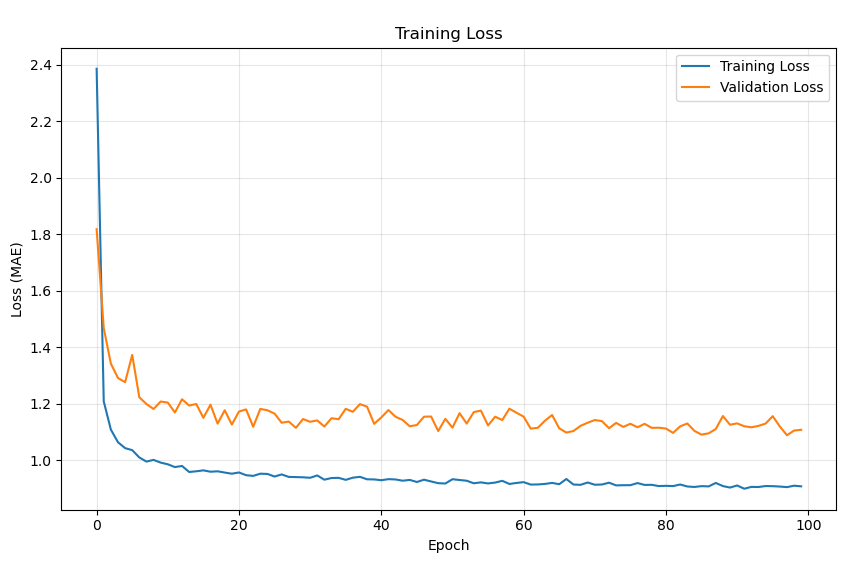

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate model
y_pred = seq.predict(X_test, verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
np.save('/home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/basic_cnn_archive/Y_pred.npy', y_pred)

In [10]:
y_pred = np.squeeze(y_pred)

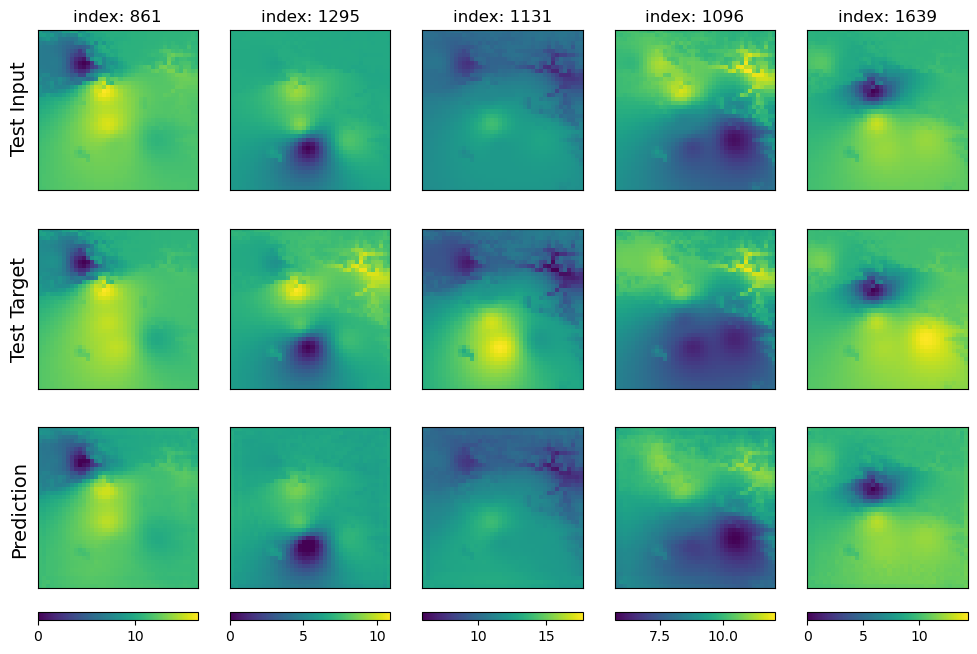

In [24]:
np.random.seed(42)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))

for c in range(axes.shape[1]):
    idx = np.random.randint(1, len(Y_test))
    vmin = np.nanmin([Y_test[idx], y_pred[idx], Y_test[idx-1]])
    vmax = np.nanmax([Y_test[idx], y_pred[idx], Y_test[idx-1]])
    
    axes[0, c].imshow(Y_test[idx-1], vmin=vmin, vmax=vmax)
    axes[0, c].set_title(f'index: {idx}')
    axes[0, c].set_xticks([])
    axes[0, c].set_yticks([])
    
    axes[1, c].imshow(Y_test[idx], vmin=vmin, vmax=vmax)
    axes[1, c].set_xticks([])
    axes[1, c].set_yticks([])

    im = axes[2, c].imshow(y_pred[idx], vmin=vmin, vmax=vmax)
    axes[2, c].set_xticks([])
    axes[2, c].set_yticks([])

    fig.colorbar(im, ax=axes[:, c], orientation='horizontal', fraction=0.046, pad=0.04)
    
fig.text(0.11, 0.775, 'Test Input', rotation=90, va='center', ha='center', fontsize=14)
fig.text(0.11, 0.525, 'Test Target', rotation=90, va='center', ha='center', fontsize=14)
fig.text(0.11, 0.275, 'Prediction', rotation=90, va='center', ha='center', fontsize=14)
plt.show()